In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import h5py
import sys

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *
import scipy.interpolate as interp
import average_envelope as env
import modulation as mod

# interpolate ev_gamma to have smooth curve
from scipy.interpolate import interp1d

colors_tot = get_colormap_colors(26, "plasma")
colors = colors_tot[:12][::-1]

In [2]:
samples_nested_all = []
mode = "cyclo"
for i in range(26):
    with h5py.File(
        f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/{mode}/result.hdf5",
        "r",
    ) as f:
        # Example: access a dataset
        posterior = f["posterior_samples"][:]

    source = f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/{mode}/pe_pack{i + 1}_{mode}.yaml"
    # extract true of source
    # Read the YAML file

    with open(source, "r") as file:
        sources = yaml.safe_load(file)["sources"]

    true = [item["injected"] for category in sources.values() for item in category]

    # Get the dtype and field names
    dtype = posterior.dtype

    label = dtype.names[: len(true)]  # first 7 parameter names

    # Stack values into a 2D array (n_samples, n_params)
    samples = np.vstack([posterior[name] for name in label]).T
    # subtract the true values
    true_as_samples = np.array(true)
    # Reshape the true values to match the shape of samples
    true_as_samples = np.tile(true_as_samples, (samples.shape[0], 1))
    samples_nested = samples - true_as_samples
    samples_nested_all.append(samples)

t1, t2 = [], []
for i in range(1, 27):
    ts, te = np.loadtxt(
        f"../data/first_year_differential_oneweek/pack_{i}/time_interval.txt"
    )
    t1.append(ts)
    t2.append(te)
t1 = np.array(t1).flatten()
t2 = np.array(t2).flatten()

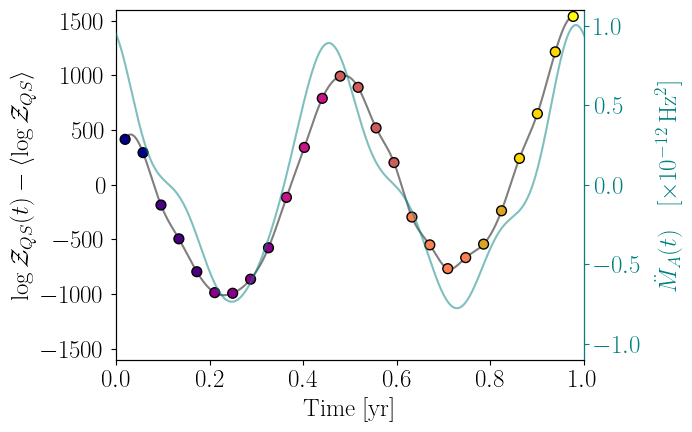

In [4]:
bf, ev_C, ev_S, bf_err = [], [], [], []

for i in range(26):
    with h5py.File(
        f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/cyclo/result.hdf5",
        "r",
    ) as f:
        ev_cyclo = f["log_evidence"][()]
        err_cyclo = f["log_evidence_error"][()]

    with h5py.File(
        f"../data/first_year_differential_oneweek/pack_{i + 1}/nested/Gamma/stat/result.hdf5",
        "r",
    ) as f:
        ev_stat = f["log_evidence"][()]
        err_stat = f["log_evidence_error"][()]

    ev_C.append(ev_cyclo)
    ev_S.append(ev_stat)

ev_S = np.array(ev_S)
ev_C = np.array(ev_C)

x = t1[1::2] / (86400 * 7)
fun = interp1d(x, ev_C - np.mean(ev_C), kind="cubic")
xnew = np.linspace(x[0], x[-1], 1000)
ev_gamma_smooth = fun(xnew)


year = 31557600.0
t = np.linspace(x[0] - 2, x[-1] + 2, 1000)
A, _ = mod.envelopes_gaussian(
    EclipticLatitude=true[5],
    EclipticLongitude=true[6],
    Psi=true[7],
    Sigma1=true[8],
    Sigma2=true[9],
    LISA_Orbital_Freq=1 / year,
    t=t * 86400 * 7,
)


# compute second derivative
A_1 = np.gradient(A**2, xnew * 86400 * 7)
A_2 = np.gradient(A_1, xnew * 86400 * 7)

tweek = t
fig, ax = plt.subplots(figsize=rect_size, layout="constrained")


ax2 = ax.twinx()
ax.set_ylabel(
    r"$\log \mathcal{Z}_{QS}(t) - \left\langle \log \mathcal{Z}_{QS}\right\rangle$"
)
ax2.set_ylabel(
    r"$\ddot{M}_A(t) \quad [\times 10^{-12}\, {\rm Hz}^2]$", color="teal", labelpad=8.0
)
ax.set_xlabel("Time [yr]")
ax2.plot(
    tweek[10:-10] * 7 * 86400 / year,
    A_2[10:-10] * 1e12,
    color="teal",
    linestyle="-",
    alpha=0.5,
    zorder=10,
)

ax.plot(
    xnew * 7 * 86400 / year,
    ev_gamma_smooth,  # - ev_gamma_smooth[0],
    color="k",
    linestyle="-",
    alpha=0.5,
    zorder=-2,
)

ax.scatter(
    x * 7 * 86400 / year,
    ev_C - np.mean(ev_C),  # - ev_gamma_smooth[0],
    marker="o",
    color=colors_tot,
    edgecolor="k",
    s=50,
    zorder=10,
)


ax2.set_xlim(0, 1)
ax.set_xlim(0, 1)
ax2.set_ylim(-1.1, 1.1)
ax.set_ylim(-1600, 1600)
ax.tick_params(axis="y", colors="k")
ax2.tick_params(axis="y", colors="teal")
ax.spines["left"].set_color("k")
ax2.spines["right"].set_color("teal")
fig.savefig("../plots/Figure6Right.pdf", bbox_inches="tight")